In [79]:
#This notebook is for model development but we are dropping movivies with movie duration greater than 300 minutes as they are outliers
#might also do some feature engineering here
#Installing initial libraries, others will be installed as we go
import pandas as pd
import numpy as np
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [80]:
#Load Dataframe
path = r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\data\processed\cleaned_movies_data.csv"
df = pd.read_csv(path)

In [81]:
#in a previous notebook, I defined a function that can be used in a pipeline to to clean the data, you can check models_dev_outliers.ipynb for that.

In [123]:
#some more feature engineering
# creating a new feature 'popularity_score' as a combination of 'ratings' and 'vote_count' to better capture movie popularity
df['popularity_score'] = (df['ratings'] * np.log1p(df['vote_count'])).astype(int)

df['decade'] = (df['year'] // 10) * 10
# This will turn 1998 into 1990, 2012 into 2010, etc
df.to_csv(r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\data\processed\cleaned_df_no_outliers.csv", index=False)

In [124]:
#Shape of data
df.shape

(17627, 10)

In [125]:
df.head()

,name,imdb_id,year,ratings,vote_count,movie_duration,movie_certification,genre,popularity_score,decade
0,Superman,tt5950044,2025,7.2,305000,129,12A,Action,90,2020
1,One Battle After Another,tt30144839,2025,8.5,15000,161,15,Action,81,2020
2,Demon Slayer: Kimetsu no Yaiba Infinity Castle,tt32820897,2025,8.6,37000,155,15,Action,90,2020
3,KPop Demon Hunters,tt14205554,2025,7.6,79000,95,PG,Action,85,2020
4,F1,tt16311594,2025,7.8,214000,155,12A,Action,95,2020


In [109]:
#Drop outliers
df = df[df["movie_duration"] <= 300] #keeping movies with duration less than 300 minutes
#Define Features X and Y
X = df.drop(["ratings", "imdb_id","name"], axis=1)
y = df["ratings"]

In [110]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 
#0.25 to set 25% of the data as test and random_state to make sure we get the same results every time we run the code 42 is just a number, could be any other number
#split the training set for validation during model training
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 
#0.2 to set 20% of the training data as validation data

In [85]:
#column groups for pipeline
num_features = ['year', 'vote_count', 'movie_duration', 'popularity_score', 'decade']
cat_features = ['genre', 'movie_certification']

In [86]:
#Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
    ("num", StandardScaler(), num_features), #to standardize the data
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ],
    remainder="passthrough" #This will allow other columns not specified in num_features and cat_features to pass through without any changes
)

In [87]:
#Building a linear regression model
lin_model = LinearRegression(n_jobs= -1)
lin_reg = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ("regressor", lin_model)
    ])

In [88]:
#train model
lin_reg.fit(X_tr, y_tr)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [89]:
#Save model with pickle
import pickle
path = r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\reg_models_without_outliers" + "\\" #pathlib can also be used
with open (path + "Nlin_reg.pickle", "wb") as to_write:
    pickle.dump(lin_reg, to_write)

#The model is saved as lin_reg.pickle in the models folder, I should comment out the saving and the fit part, but the model didnt take long to train so I won't comment it out

In [90]:
#Read the saved model
with open (path + "Nlin_reg.pickle", "rb") as to_read:
    lin_reg = pickle.load(to_read)

In [91]:
#predict on valuation set
y_pred = lin_reg.predict(X_val)

In [92]:
#Model evaluation
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

MAE: 0.460
MSE: 0.434
RMSE: 0.659
R²: 0.628


In [93]:
#define a function that develops the model and saves it and runs the test and saves the result as df
#I'll concatenate the results of each model to find the best model
#but in the last notebook, the function will run for all at once and return the concanated result
def model_dev(model, model_name):
    reg = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ("regressor", model)
    ])
    #train model
    reg.fit(X_tr, y_tr)
    #Save model with pickle
    path = r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\reg_models_without_outliers" + "\\"
    filename = f"{model_name}.pickle" #N for no outliers
    with open (path + filename, "wb") as to_write:
        pickle.dump(reg, to_write)
    #Read the saved model

    #predict on test set
    y_pred = reg.predict(X_val)
    #Model evaluation
    mae = round(mean_absolute_error(y_val, y_pred), 3)
    mse = round(mean_squared_error(y_val, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    r2 = round(r2_score(y_val, y_pred), 3)
    #make result dataframe
    result_df = pd.DataFrame({"model": [model_name],
                                    "MAE": [mae],
                                    "MSE":[mse],
                                    "RMSE":[rmse],
                                    "R2":[r2]})
    globals()[f"{model_name}_result"] = result_df
    return result_df

#applying function not necessary, but to confirm the result above
lin_model = LinearRegression(n_jobs= -1)
model_dev(lin_model, "lin_reg")

,model,MAE,MSE,RMSE,R2
0,lin_reg,0.46,0.434,0.659,0.628


In [94]:
#Decision Tree Regressor model
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=42)
model_dev(tree_model, "tree_reg")
all_results = pd.concat([lin_reg_result, tree_reg_result], ignore_index=True)
all_results


,model,MAE,MSE,RMSE,R2
0,lin_reg,0.460,0.434,0.659,0.628
1,tree_reg,0.055,0.013,0.114,0.989


In [95]:
#Random Forest Models and Ensemble models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
model_dev(rf, "rf_reg")
all_results = pd.concat([all_results, rf_reg_result], ignore_index=True)
all_results

,model,MAE,MSE,RMSE,R2
0,lin_reg,0.460,0.434,0.659,0.628
1,tree_reg,0.055,0.013,0.114,0.989
2,rf_reg,0.042,0.007,0.084,0.994


In [96]:
#Gradientboosting model
gb = GradientBoostingRegressor(random_state=42)
model_dev(gb, "gb_reg")
all_results = pd.concat([all_results, gb_reg_result], ignore_index=True)
all_results

,model,MAE,MSE,RMSE,R2
0,lin_reg,0.460,0.434,0.659,0.628
1,tree_reg,0.055,0.013,0.114,0.989
2,rf_reg,0.042,0.007,0.084,0.994
3,gb_reg,0.125,0.033,0.182,0.972


In [97]:
#Instantiate and train AdaBoostRegressor
from sklearn.ensemble import AdaBoostRegressor


ab = AdaBoostRegressor(random_state=42)
model_dev(ab, "ab_reg")
all_results = pd.concat([all_results, ab_reg_result], ignore_index=True)
all_results


,model,MAE,MSE,RMSE,R2
0,lin_reg,0.460,0.434,0.659,0.628
1,tree_reg,0.055,0.013,0.114,0.989
2,rf_reg,0.042,0.007,0.084,0.994
3,gb_reg,0.125,0.033,0.182,0.972
4,ab_reg,0.407,0.267,0.517,0.770


In [98]:
#instantiate and train XGBRegressor
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=42)
model_dev(xgb, "xgb_reg")
all_results = pd.concat([all_results, xgb_reg_result], ignore_index=True)
all_results


,model,MAE,MSE,RMSE,R2
0,lin_reg,0.460,0.434,0.659,0.628
1,tree_reg,0.055,0.013,0.114,0.989
2,rf_reg,0.042,0.007,0.084,0.994
3,gb_reg,0.125,0.033,0.182,0.972
4,ab_reg,0.407,0.267,0.517,0.770
5,xgb_reg,0.055,0.007,0.084,0.994


In [99]:
#saving the models results as csv
all_results.sort_values(by="MSE").to_csv(r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\reports\models_result\No_Outliers_reg.csv", index=False)

In [100]:
all_results.sort_values(by="MSE")

,model,MAE,MSE,RMSE,R2
2,rf_reg,0.042,0.007,0.084,0.994
5,xgb_reg,0.055,0.007,0.084,0.994
1,tree_reg,0.055,0.013,0.114,0.989
3,gb_reg,0.125,0.033,0.182,0.972
4,ab_reg,0.407,0.267,0.517,0.770
0,lin_reg,0.460,0.434,0.659,0.628


In [ ]:
#I am not tunning the models because they already perform so well explaining variability in the target variabile up to 99.4%
#I am going with xgb model as my champion model becauase its performance is great and has the least training time
with open (path + "xgb_reg.pickle", "rb") as to_read:
    xgb_reg = pickle.load(to_read)

In [103]:
#fit model on both training and validation set i.en X_train and y_train
xgb_reg.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [104]:
#save model
with open(path+"xgb_reg_final.pickle", "wb") as to_write:
    pickle.dump(xgb_reg, to_write)

In [113]:
#predict with the best estimator
y_pred = xgb_reg.predict(X_test)

In [112]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13220, 7), (13220,), (4407, 7), (4407,))

In [ ]:
#You can train the model on the whole dataset if it does well with the test set before production deployment
#Model evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

#make result dataframe
final_model_result_df = pd.DataFrame({"model": "xgb_reg_final",
                                "MAE": [mae],
                                "MSE":[mse],
                                "RMSE":[rmse],
                                "R2":[r2]})
final_model_result_df.to_csv(r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\reports\models_result\final_XGB_reult.csv", index=False)
final_model_result_df


,model,MAE,MSE,RMSE,R2
0,xgb_reg_final,0.05614,0.007456,0.086347,0.993318


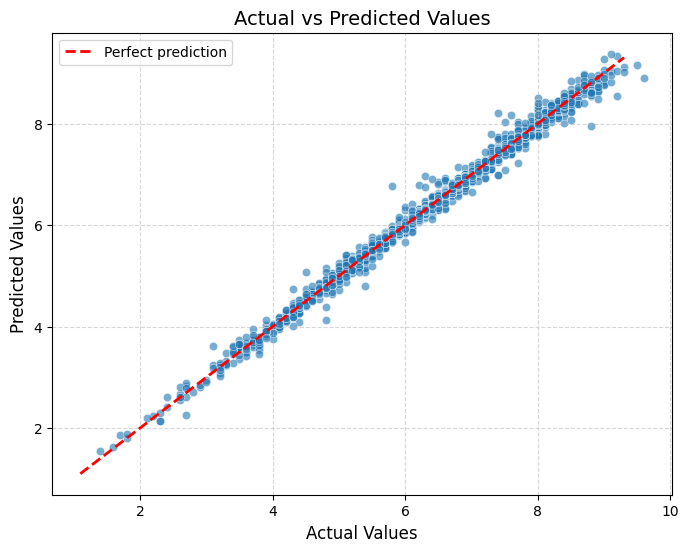

In [153]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe for easy plotting
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Actual", y="Predicted", data=comparison_df, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label="Perfect prediction")

plt.title("Actual vs Predicted Values", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\reports\models_result\Reg_Actual_vs_Predicted.png")
plt.show()


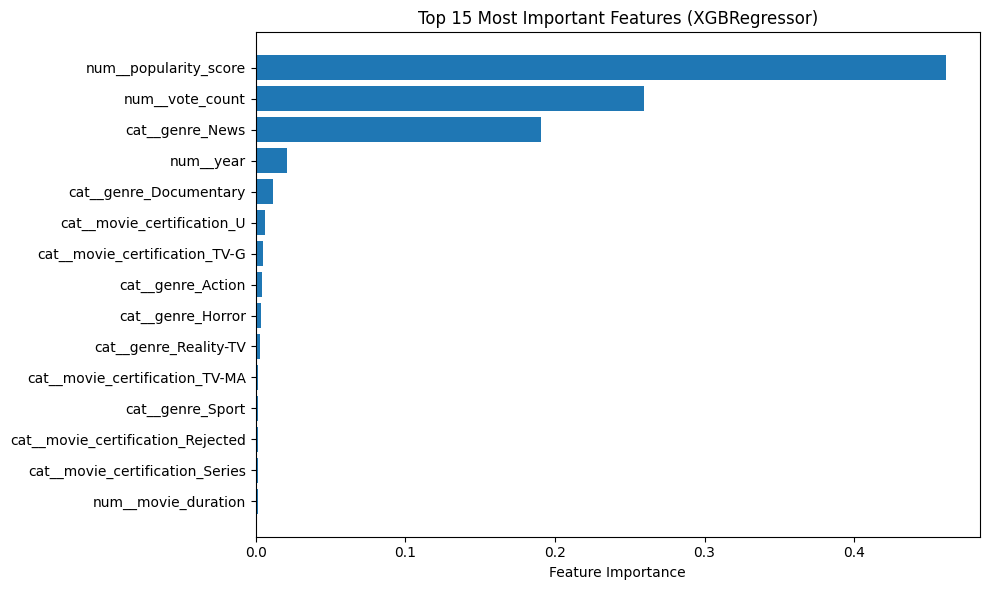

In [152]:
#Feature Importance Plot for XGBRegressor
# Load the trained model
with open (path + "xgb_reg_final.pickle", "rb") as to_read:
    xgb_pipe = pickle.load(to_read)
# Extract the trained XGBRegressor from the pipeline
xgb_model = xgb_pipe.named_steps["regressor"]

# Get feature names from the preprocessor
# (handles both numerical + one-hot encoded categorical features)
feature_names = xgb_pipe.named_steps["preprocessor"].get_feature_names_out()

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for easy plotting
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.barh(feat_imp["Feature"][:15][::-1], feat_imp["Importance"][:15][::-1])  # Top 15 features
plt.xlabel("Feature Importance")
plt.title("Top 15 Most Important Features (XGBRegressor)")
plt.tight_layout()
plt.savefig(r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\reports\models_result\XGB_Reg_feature_importance.png")
plt.show()


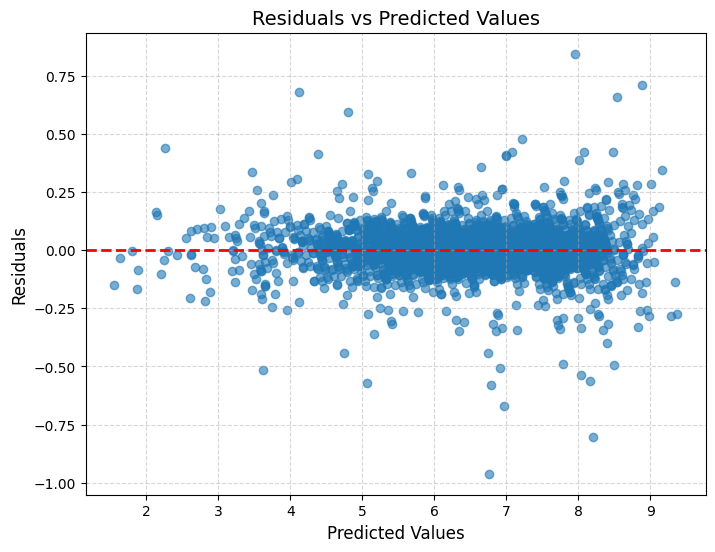

In [151]:
#homoscedasticity
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title("Residuals vs Predicted Values", fontsize=14)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\reports\models_result\Reg_residuals_vs_predicted.png")
plt.show()

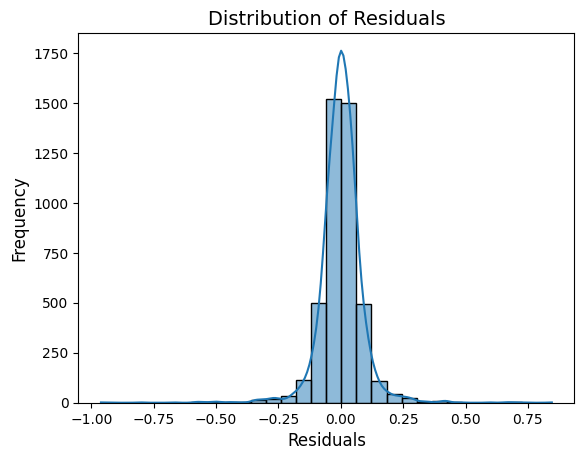

In [150]:
#Normality of residuals
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Residuals", fontsize=14)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.savefig(r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\reports\models_result\Reg_residuals_dist.png")
plt.show()

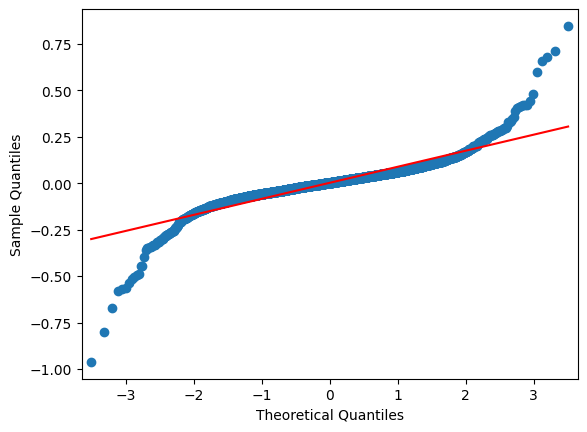

In [148]:
#Normality of residuals using Q-Q plot
import statsmodels.api as sm
sm.qqplot(residuals, line ='s')
plt.savefig(r"C:\Users\HP\Desktop\UI\important\Data Science\movie-success-prediction\reports\models_result\Reg_Q-Q_plot.png")
plt.show()